In [24]:
import pandas as pd
import os, sys
import numpy as np
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root_path not in sys.path:
    sys.path.append(project_root_path)

from src.utils import load_dataset
from src.utils import show_mnist
from sklearn.model_selection import train_test_split

from src import train, predict, test
from torchinfo import summary
import mlflow

## 1. Load dataset

In [13]:
DATA_DIR = '../data'
dataset = load_dataset(DATA_DIR)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    dataset[0], dataset[1], 
    test_size=0.1,
    random_state=42
)

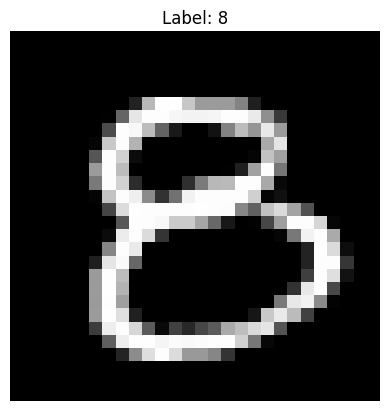

In [15]:
show_mnist(X_train[0], y_train[0])

## 2. Build Neural Network for task 01

To see the neural network in detail, access `lesson-01/src/ANN/T1.py`.

In [16]:
from src.ANN.T1 import T1

In [17]:
t1_example = T1()
batch_size = 1
input_shape = (batch_size, 1, 28, 28) 

print(f'Intput shape: {input_shape}')
# 3. Print the summary
summary(t1_example, input_size=input_shape)

Intput shape: (1, 1, 28, 28)


Layer (type:depth-idx)                   Output Shape              Param #
T1                                       [1, 10]                   --
├─Linear: 1-1                            [1, 512]                  401,920
├─Linear: 1-2                            [1, 10]                   5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.63
Estimated Total Size (MB): 1.64

### 2.1. Training model

In [23]:
train.train(
    X_data=X_train,
    y_data=y_train,
    model_class=T1,
    LEARNING_RATE=0.0001,
    BATCH_SIZE=256,
    EPOCHS=10,
    MLFLOW_EXPERIMENT_NAME="T1_Classification"
)

Đang chuẩn bị và chia dữ liệu...
Chuẩn bị dữ liệu thành công!
Bắt đầu MLflow run: 879e2e34951b4633bb322d49e74c4dfd
Epoch 1/10 - Val Loss: 1.6493, Val Accuracy: 81.16%
Epoch 2/10 - Val Loss: 1.6245, Val Accuracy: 83.59%
Epoch 3/10 - Val Loss: 1.6131, Val Accuracy: 84.75%
Epoch 4/10 - Val Loss: 1.5306, Val Accuracy: 92.98%
Epoch 5/10 - Val Loss: 1.5159, Val Accuracy: 94.52%
Epoch 6/10 - Val Loss: 1.5191, Val Accuracy: 94.17%
Epoch 7/10 - Val Loss: 1.5093, Val Accuracy: 95.19%
Epoch 8/10 - Val Loss: 1.5033, Val Accuracy: 95.79%
Epoch 9/10 - Val Loss: 1.5015, Val Accuracy: 95.98%


2025/10/08 17:24:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 10/10 - Val Loss: 1.5024, Val Accuracy: 95.86%
Training hoàn tất. Đang lưu model vào MLflow...


2025/10/08 17:24:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/08 17:24:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/08 17:24:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Lưu model thành công!


### 2.2. Evaluating model

In [25]:
id = '879e2e34951b4633bb322d49e74c4dfd'
model = mlflow.pytorch.load_model(f"runs:/{id}/model")

In [29]:
accuracy = test.evaluate(model, X_val, y_val)
print(f'{round(accuracy, 3)}%')

95.529%


## 3. Build Neural Network for task 02

In [30]:
from src.ANN.T2 import T2

In [31]:
t2_example = T2()
batch_size = 1
input_shape = (batch_size, 1, 28, 28) 

print(f'Intput shape: {input_shape}')
# 3. Print the summary
summary(t2_example, input_size=input_shape)

Intput shape: (1, 1, 28, 28)


Layer (type:depth-idx)                   Output Shape              Param #
T2                                       [1, 10]                   --
├─Linear: 1-1                            [1, 512]                  401,920
├─Linear: 1-2                            [1, 256]                  131,328
├─Linear: 1-3                            [1, 10]                   2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
Total mult-adds (M): 0.54
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.14
Estimated Total Size (MB): 2.15

### 3.1. Training model

In [32]:
train.train(
    X_data=X_train,
    y_data=y_train,
    model_class=T2,
    LEARNING_RATE=0.0001,
    BATCH_SIZE=256,
    EPOCHS=10,
    MLFLOW_EXPERIMENT_NAME="T2_Classification"
)

2025/10/08 17:35:36 INFO mlflow.tracking.fluent: Experiment with name 'T2_Classification' does not exist. Creating a new experiment.


Đang chuẩn bị và chia dữ liệu...
Chuẩn bị dữ liệu thành công!
Bắt đầu MLflow run: 9ee206d29a8d450e851c68013f1a35f8
Epoch 1/10 - Val Loss: 1.7085, Val Accuracy: 75.19%
Epoch 2/10 - Val Loss: 1.6120, Val Accuracy: 84.84%
Epoch 3/10 - Val Loss: 1.5027, Val Accuracy: 95.84%
Epoch 4/10 - Val Loss: 1.4983, Val Accuracy: 96.40%
Epoch 5/10 - Val Loss: 1.4997, Val Accuracy: 96.14%
Epoch 6/10 - Val Loss: 1.4972, Val Accuracy: 96.46%
Epoch 7/10 - Val Loss: 1.4943, Val Accuracy: 96.71%
Epoch 8/10 - Val Loss: 1.4932, Val Accuracy: 96.83%
Epoch 9/10 - Val Loss: 1.4893, Val Accuracy: 97.29%


2025/10/08 17:35:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 10/10 - Val Loss: 1.4908, Val Accuracy: 97.13%
Training hoàn tất. Đang lưu model vào MLflow...


2025/10/08 17:35:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/08 17:35:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/08 17:35:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Lưu model thành công!


### 3.2. Evaluating model

In [33]:
id = '9ee206d29a8d450e851c68013f1a35f8'
model = mlflow.pytorch.load_model(f"runs:/{id}/model")
accuracy = test.evaluate(model, X_val, y_val)
print(f'{round(accuracy, 3)}%')

96.771%


## 4. Build Convolutional Neural Network

### 4.1. Convolutional Neural Layer

In [ ]:
def do_cnn_layer(image, kernel = None):
    '''
    Thực hiện phép tích chập 2D đơn giản trên một ảnh.
    '''
    N = image.shape[0]
    new_image = np.zeros((N, N))
    if kernel is None:
        kernel = np.array([
            [1,  1,  1],
            [1, -8,  1],
            [1,  1,  1]
        ])

    for i in range(1, N - 1):
        for j in range(1, N - 1):
            image_patch = image[i-1:i+2, j-1:j+2]
            new_pixel_value = np.sum(image_patch * kernel)
            new_image[i, j] = new_pixel_value
    
    return new_image

### 4.2. Pooling Layer

In [ ]:
def max_pooling_layer(feature_map, pool_size=2, stride=2):
    """
    Thực hiện Max Pooling trên một bản đồ đặc trưng (feature map).
    
    Args:
        feature_map (np.array): Ma trận đầu vào (kết quả từ lớp CNN).
        pool_size (int): Kích thước của cửa sổ pooling (ví dụ: 2 nghĩa là 2x2).
        stride (int): Bước nhảy của cửa sổ.
        
    Returns:
        np.array: Ma trận đầu ra đã được giảm kích thước.
    """
    input_height, input_width = feature_map.shape
    
    # Tính toán kích thước của ma trận đầu ra
    output_height = (input_height - pool_size) // stride + 1
    output_width = (input_width - pool_size) // stride + 1
    
    # Tạo ma trận đầu ra với các giá trị 0
    pooled_map = np.zeros((output_height, output_width))
    
    # Bắt đầu trượt cửa sổ qua ma trận đầu vào
    for i in range(output_height):
        for j in range(output_width):
            # Xác định vị trí của cửa sổ hiện tại
            start_i = i * stride
            start_j = j * stride
            end_i = start_i + pool_size
            end_j = start_j + pool_size
            
            # Cắt ra cửa sổ từ feature map
            window = feature_map[start_i:end_i, start_j:end_j]
            
            # Lấy giá trị lớn nhất trong cửa sổ và gán vào ma trận đầu ra
            pooled_map[i, j] = np.max(window)
            
    return pooled_map

### 4.3. Demo logic

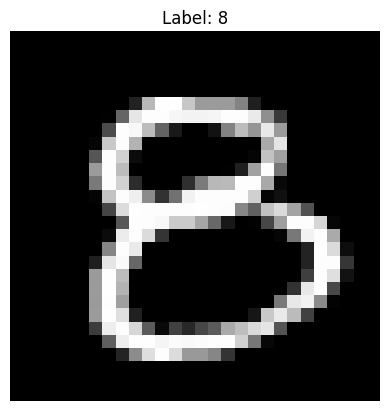

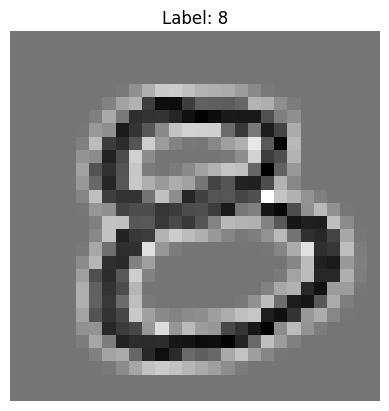

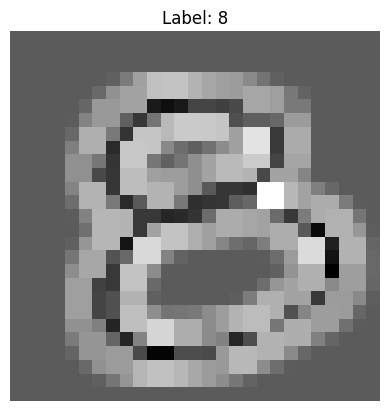

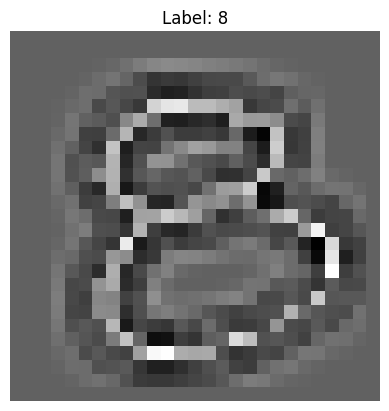

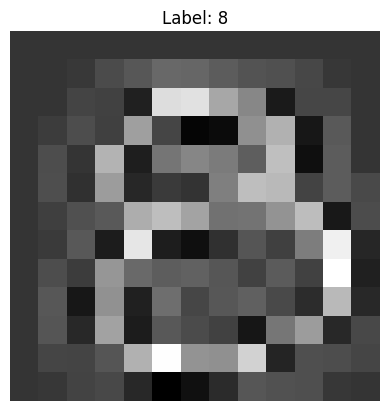

In [ ]:
images = [X_train[0] for i in range(5)]
images[1] = do_cnn_layer(images[0])
images[2] = max_pooling_layer(images[1], pool_size=2, stride=1) * 1e9 * 1e9 
images[3] = do_cnn_layer(images[2])
images[4] = max_pooling_layer(images[3])

for i in range(5):
    show_mnist(images[i], y_train[0])

### 4.4. Full logic

See more at `lesson-01/src/ANN/CNN.py`.

In [34]:
from src.ANN.CNN import CNN

In [36]:
CNN_example = CNN()
batch_size = 1
input_shape = (batch_size, 1, 28, 28) 

print(f'Intput shape: {input_shape}')
# 3. Print the summary
summary(CNN_example, input_size=input_shape)

Intput shape: (1, 1, 28, 28)


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─MaxPool2d: 1-2                         [1, 16, 13, 13]           --
├─Conv2d: 1-3                            [1, 32, 13, 13]           4,640
├─MaxPool2d: 1-4                         [1, 32, 6, 6]             --
├─Linear: 1-5                            [1, 10]                   11,530
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
Total mult-adds (M): 0.92
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.07
Estimated Total Size (MB): 0.21

In [37]:
train.train(
    X_data=X_train,
    y_data=y_train,
    model_class=CNN,
    LEARNING_RATE=0.0001,
    BATCH_SIZE=256,
    EPOCHS=10,
    MLFLOW_EXPERIMENT_NAME="T2_Classification"
)

Đang chuẩn bị và chia dữ liệu...
Chuẩn bị dữ liệu thành công!
Bắt đầu MLflow run: 59c886a895f34d0588e58d933f620ead
Epoch 1/10 - Val Loss: 0.7395, Val Accuracy: 85.38%
Epoch 2/10 - Val Loss: 0.3941, Val Accuracy: 91.75%
Epoch 3/10 - Val Loss: 0.2642, Val Accuracy: 94.11%
Epoch 4/10 - Val Loss: 0.2211, Val Accuracy: 95.21%
Epoch 5/10 - Val Loss: 0.1925, Val Accuracy: 95.63%
Epoch 6/10 - Val Loss: 0.1587, Val Accuracy: 96.46%
Epoch 7/10 - Val Loss: 0.1449, Val Accuracy: 96.86%
Epoch 8/10 - Val Loss: 0.1323, Val Accuracy: 97.00%
Epoch 9/10 - Val Loss: 0.1257, Val Accuracy: 97.25%


2025/10/08 17:38:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 10/10 - Val Loss: 0.1249, Val Accuracy: 97.19%
Training hoàn tất. Đang lưu model vào MLflow...


2025/10/08 17:38:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/08 17:38:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/08 17:38:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Lưu model thành công!


In [38]:
id = '59c886a895f34d0588e58d933f620ead'
model = mlflow.pytorch.load_model(f"runs:/{id}/model")
accuracy = test.evaluate(model, X_val, y_val)
print(f'{round(accuracy, 3)}%')

96.843%
